<p>In this notebook, we'll see how to fine-tune a NLLB-200 machine translation model for a new language.</p>
<p><a href="https://cointegrated.medium.com/how-to-fine-tune-a-nllb-200-model-for-translating-a-new-language-a37fc706b865">https://cointegrated.medium.com/how-to-fine-tune-a-nllb-200-model-for-translating-a-new-language-a37fc706b865</a></p>

# 0. Preliminaries

Installing dependencies:
* `transformers`, as a neural network framework
* `sentencepiece`, a backend for my tokenizer (the algorithm for converting a text into symbols from the model's vocabulary)
* `sacremoses`, a package required for text preprocessing with which NLLB models were pretrained.
* `sacrebleu`, a package for evaluating translation models

In [1]:
CUDA_CORE=0
# MODEL_USED="facebook/nllb-200-distilled-600M"
MODEL_USED="facebook/nllb-200-1.3B"
# MODEL_USED="facebook/nllb-200-3.3B"
MODEL_SAVE_PATH="models/nllb_wayuu_esp_completo_1_3B-V2"
LANGUAGE_ORIGIN_LABEL="spa_Latn"
LANGUAGE_TARGET_LABEL="way_Latn"
LANGUAGE_SIMILAR_LABEL="ayr_Latn" # Central Aymara
LANGUAGE_FILE="data/wayuu_completo_v2.csv"
LANGUAGE_FILE_ORIGIN_LABEL="esp"
LANGUAGE_FILE_TARGET_LABEL="way"
NORMALIZER_LANGUAGE="es"
!mkdir -p {MODEL_SAVE_PATH}

In [2]:
import locale
def gpe(x=None):
    return "UTF-8"
locale.getpreferredencoding = gpe

In [3]:
!pip install sentencepiece transformers==4.33 datasets sacremoses sacrebleu  -q

In [4]:
!pip install ipywidgets

In [5]:
!pip install scikit-learn
import pandas as pd
from sklearn.model_selection import train_test_split

<h1 id="1.-Exploring-the-data">1. Exploring the data</h1>
<p>&nbsp;</p>

In [6]:
trans_df = pd.read_csv(LANGUAGE_FILE)
print(trans_df.shape)
print(trans_df.columns)

(82218, 2)
Index(['esp', 'way'], dtype='object')


In [7]:
df_train, df_devtest = train_test_split(trans_df, test_size=0.2, random_state=42)
df_dev, df_test = train_test_split(df_devtest, test_size=0.5, random_state=42)

In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 65774 entries, 3636 to 15795
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   esp     65774 non-null  object
 1   way     65774 non-null  object
dtypes: object(2)
memory usage: 1.5+ MB


In [9]:
df_train.head()

,esp,way
3636,tom termino,aja'lajashi tom
44110,para alguien asi la voz de jehova sera apenas ...,müle nukuwa'ipa chia wayuukai müsü mo'ukai saa...
14023,estoy bajo arresto,püreesainjachi taya
28739,si eres joven y estas pensando que hacer con t...,jiakana jima'aliikana otta majayünnüükana kasa...
34186,la biblia garantiza cuantas cosas sean verdade...,müsü tü wiwüliakat taso'ira aa'inchii joolu'u ...


In [10]:
df_dev.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8222 entries, 53972 to 43485
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   esp     8222 non-null   object
 1   way     8222 non-null   object
dtypes: object(2)
memory usage: 192.7+ KB


In [11]:
df_dev.head()

,esp,way
53972,algunas traducciones de la biblia dicen que di...,saashin waneeirua wiwülia amaanüshi enoc nutum...
82125,No aceptes acusación contra un presbítero a no...,"Müleka “kaainjalashi chira laülaashikai”, pümü..."
72822,joven preferirias estar en una congregacion do...,jiakana jima'aliikana otta majayünnüükana shia...
41181,eso demuestra que se preocupa por cada uno de ...,sükajee tia nii'iyatüin wamüin nükaaliinjeein ...
61519,pero no debemos pensar que son nuestros padres...,nayapeje'e aneeküin süka naa'in namüiwa'a na t...


In [12]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8222 entries, 36372 to 10137
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   esp     8222 non-null   object
 1   way     8222 non-null   object
dtypes: object(2)
memory usage: 192.7+ KB


In [13]:
df_test.head()

,esp,way
36372,dios tomo muchas otras medidas para cumplir su...,wainma tü kasa naainjakat maleiwa süpüla niker...
36830,este sistema satanico entro en sus ultimos dia...,o'ttüsü tü ka'i saja'ttajatkalü o'u tü kasa nu...
63307,b por que tenemos que prepararnos ahora para s...,maa'ulu yaa eesüja'a nnojorüle wapüleeruaanüin...
65763,saberlo nos ayudara a ver el matrimonio y sus ...,watüjaale saa'u tia nnojoleerü jülüjain waa'in...
26243,ah estas ahi todavia,aa naayüiya pia yalaala


# 2. How well does the data fit into a NLLB tokenizer?

In [14]:
from transformers import NllbTokenizer
from tqdm.auto import tqdm, trange

In [15]:
tokenizer = NllbTokenizer.from_pretrained(MODEL_USED)

In [16]:
import re

def word_tokenize(text):
    # a very naive word tokenizer for languages with English-like orthography
    return re.findall('(\w+|[^\w\s])', text)

In [17]:
smpl = df_train.sample(10000, random_state=42, replace=True)
smpl[LANGUAGE_FILE_ORIGIN_LABEL + '_toks'] = smpl[LANGUAGE_FILE_ORIGIN_LABEL].apply(tokenizer.tokenize)
smpl[LANGUAGE_FILE_TARGET_LABEL + '_toks'] = smpl[LANGUAGE_FILE_TARGET_LABEL].apply(tokenizer.tokenize)

smpl[LANGUAGE_FILE_ORIGIN_LABEL + '_words'] = smpl[LANGUAGE_FILE_ORIGIN_LABEL].apply(word_tokenize)
smpl[LANGUAGE_FILE_TARGET_LABEL + '_words'] = smpl[LANGUAGE_FILE_TARGET_LABEL].apply(word_tokenize)

In [18]:
smpl.sample(5)[[LANGUAGE_FILE_ORIGIN_LABEL, LANGUAGE_FILE_ORIGIN_LABEL + '_words', LANGUAGE_FILE_ORIGIN_LABEL + '_toks', LANGUAGE_FILE_TARGET_LABEL, LANGUAGE_FILE_TARGET_LABEL + '_words', LANGUAGE_FILE_TARGET_LABEL + '_toks']]

,esp,esp_words,esp_toks,way,way_words,way_toks
49117,por que se declara justos a aquellos que son r...,"[por, que, se, declara, justos, a, aquellos, q...","[▁por, ▁que, ▁se, ▁declara, ▁just, os, ▁a, ▁aq...",naa'inrüin tü anasükat jamüshi nümaka jesuu na...,"[naa, ', inrüin, tü, anasükat, jamüshi, nümaka...","[▁naa, ', in, rü, in, ▁tü, ▁anas, ü, kat, ▁jam..."
60872,no buscan a otros ungidos para hablar o estudi...,"[no, buscan, a, otros, ungidos, para, hablar, ...","[▁no, ▁bus, can, ▁a, ▁otros, ▁ung, idos, ▁para...",nnojoishii nachajaain na wanee aneekuushikana ...,"[nnojoishii, nachajaain, na, wanee, aneekuushi...","[▁nno, jo, ishi, i, ▁na, cha, jaa, in, ▁na, ▁w..."
30461,a por que debemos seguir creciendo en conocimi...,"[a, por, que, debemos, seguir, creciendo, en, ...","[▁a, ▁por, ▁que, ▁debemos, ▁seguir, ▁cre, cien...",makalaka wekirajaainjanain sünain tü waainjaka...,"[makalaka, wekirajaainjanain, sünain, tü, waai...","[▁maka, laka, ▁wek, ira, jaa, in, jana, in, ▁s..."
76114,¡Y teníamos derecho a ello! Pero quisimos ofre...,"[¡, Y, teníamos, derecho, a, ello, !, Pero, qu...","[▁¡, Y, ▁ten, íamos, ▁derecho, ▁a, ▁ello, !, ▁...",Anasüyaaje müleka wawalaajünüle jütüma wanaa s...,"[Anasüyaaje, müleka, wawalaajünüle, jütüma, wa...","[▁An, as, ü, yaa, je, ▁mü, leka, ▁wa, wala, aj..."
10050,ellas cenaron,"[ellas, cenaron]","[▁ellas, ▁cen, aron]",eküinapa naya,"[eküinapa, naya]","[▁ek, ü, in, apa, ▁naya]"


In [19]:
stats = smpl[[LANGUAGE_FILE_ORIGIN_LABEL + '_toks', LANGUAGE_FILE_TARGET_LABEL + '_toks', LANGUAGE_FILE_ORIGIN_LABEL + '_words', LANGUAGE_FILE_TARGET_LABEL + '_words']].applymap(len).describe()
stats

/tmp/ipykernel_319415/105503015.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  stats = smpl[[LANGUAGE_FILE_ORIGIN_LABEL + '_toks', LANGUAGE_FILE_TARGET_LABEL + '_toks', LANGUAGE_FILE_ORIGIN_LABEL + '_words', LANGUAGE_FILE_TARGET_LABEL + '_words']].applymap(len).describe()


,esp_toks,way_toks,esp_words,way_words
count,10000.000000,10000.000000,10000.0000,10000.000000
mean,15.535200,29.061000,12.2735,14.572600
std,17.891768,35.749611,14.1708,18.101378
min,1.000000,1.000000,1.0000,1.000000
25%,5.000000,10.000000,4.0000,5.000000
50%,13.000000,23.000000,10.0000,11.000000
75%,22.000000,40.000000,18.0000,20.000000
max,1162.000000,2461.000000,930.0000,1239.000000


In [20]:
print(stats[LANGUAGE_FILE_ORIGIN_LABEL + "_toks"]['mean'] / stats[LANGUAGE_FILE_ORIGIN_LABEL + "_words"]['mean'])
print(stats[LANGUAGE_FILE_TARGET_LABEL + "_toks"]['mean'] / stats[LANGUAGE_FILE_TARGET_LABEL + "_words"]['mean'])

1.265751415651607
1.99422203313067


In [21]:
print(tokenizer.unk_token, tokenizer.unk_token_id)

<unk> 3


<p>One more check: how often does the token happen in the tokenizer output for quechua? If this is too often, we need to fix it somehow</p>

In [22]:
texts_with_unk = [text for text in tqdm(trans_df[LANGUAGE_FILE_TARGET_LABEL]) if tokenizer.unk_token_id in tokenizer(text).input_ids]
print(len(texts_with_unk))

  0%|          | 0/82218 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1150 > 1024). Running this sequence through the model will result in indexing errors


2806


In [23]:
import random
s = random.sample(texts_with_unk, 5)
s

["nüchuntüin nümüin süka süpüshua naa'in sünain nümüin nümüin:—Kaalin taya püpüla, amotsojünüsü saa'in tü tachonkot sütüma wane ayuulii. Tatüjaa aa'ulu müleka pu'unüle sünainmüin sümaa pi'itaainjatüin pajapü sünain, kateerü o'u süchikua —nümakalaka nümüin Jesús.",
 "Je kettaapa süka'iya tü a'ttieekat süpüla sütpajünüin, nüjütüin wane nüchepchia nanainmüin na aa'inmajüliikana sünain maa namüin: ‘Anakaja juluwataale tamüin süpüshi süchon tü ta'ttia jükotchajalakat, tü tamüinjatkat jütüma saa'u takoroloin shia’.",
 "“Shiasa mapa kakalia süchikijee, nüle'ejakalaka chi washitshikai nipialu'umüin süpüla nütüjaainjatüin saa'u sukuaippa tü neerü ni'itaakat paala najapulu'u na nüchepchiakana.",
 "Müshi joo Pedro nümüin Jesús:—Wapütüin süpüshua tü kasa eejatkat wama'ana süpüla yaainjanain waya pümaa. ¿Kasakalaka nuwalaajeenain aka waya Maleiwa? —nümakalaka.",
 "“Je joolu'u, motsomüin yaain taya jümaa. Shiasa palitchon ka'i, ji'reechi taya tachikua”, nümakalaka Jesús namüin na nikirajüinkana.Jamü

In [24]:
# this code is adapted from  the Stopes repo of the NLLB team
# https://github.com/facebookresearch/stopes/blob/main/stopes/pipelines/monolingual/monolingual_line_processor.py#L214

import re
import sys
import typing as tp
import unicodedata
from sacremoses import MosesPunctNormalizer


mpn = MosesPunctNormalizer(lang=NORMALIZER_LANGUAGE)
mpn.substitutions = [
    (re.compile(r), sub) for r, sub in mpn.substitutions
]


def get_non_printing_char_replacer(replace_by: str = " ") -> tp.Callable[[str], str]:
    non_printable_map = {
        ord(c): replace_by
        for c in (chr(i) for i in range(sys.maxunicode + 1))
        # same as \p{C} in perl
        # see https://www.unicode.org/reports/tr44/#General_Category_Values
        if unicodedata.category(c) in {"C", "Cc", "Cf", "Cs", "Co", "Cn"}
    }

    def replace_non_printing_char(line) -> str:
        return line.translate(non_printable_map)

    return replace_non_printing_char

replace_nonprint = get_non_printing_char_replacer(" ")

def preproc(text):
    clean = mpn.normalize(text)
    clean = replace_nonprint(clean)
    # replace 𝓕𝔯𝔞𝔫𝔠𝔢𝔰𝔠𝔞 by Francesca
    clean = unicodedata.normalize("NFKC", clean)
    return clean

In [25]:
texts_with_unk_normed = [text for text in tqdm(texts_with_unk) if tokenizer.unk_token_id in tokenizer(preproc(text)).input_ids]
print(len(texts_with_unk_normed))

  0%|          | 0/2806 [00:00<?, ?it/s]

0


<h1 id="3.-Adding-a-new-language-tag-to-the-tokenizer-and-model">3. Expanding the vocabulary</h1>

In [26]:
from collections import Counter
all_texts = trans_df[LANGUAGE_FILE_TARGET_LABEL]
all_text_normalized = [preproc(t) for t in tqdm(all_texts)]
chars_cnt = Counter(c for t in all_text_normalized for c in t)
required_chars = ''.join([
    k for k, v in chars_cnt.most_common() 
    if v >= 3 and k not in ' '
])

  0%|          | 0/82218 [00:00<?, ?it/s]

In [27]:
all_texts_file = MODEL_SAVE_PATH + "/all_texts_file.csv"
trans_df[LANGUAGE_FILE_TARGET_LABEL].to_csv(all_texts_file, sep='|', index=False, header=False)

In [28]:
import sentencepiece as spm

SPM_PREFIX = MODEL_SAVE_PATH + '/spm_16k'
with open(all_texts_file, 'w') as f:
    for i, text in enumerate(all_texts):
        print(text, file=f)

spm.SentencePieceTrainer.train(
    input=all_texts_file,
    model_prefix=SPM_PREFIX,
    vocab_size=2**14,  # 16K
    character_coverage = 1,
    num_threads=16,
    train_extremely_large_corpus=False,
    add_dummy_prefix=False,
    max_sentencepiece_length=128,
    max_sentence_length=4192*4,
    pad_id=0,
    eos_id=1,
    unk_id=2,
    bos_id=-1,
    required_chars=required_chars,
)

sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: models/nllb_wayuu_esp_completo_1_3B-V2/all_texts_file.csv
  input_format: 
  model_prefix: models/nllb_wayuu_esp_completo_1_3B-V2/spm_16k
  model_type: UNIGRAM
  vocab_size: 16384
  self_test_sample_size: 0
  character_coverage: 1
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 16768
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 128
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: ainüetsukjl'mwohpryc.,dJMbNgASú-":vfOTPC¿?EízWéqKxáI23ó14LBGD5YFꞋꞌH70R6[]89Z¡!;)ñÉ(UØVÜ/_
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_sentencepieces_file: 
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 2

In [29]:
!pip install protobuf==3.19.4

In [30]:
!wget https://raw.githubusercontent.com/protocolbuffers/protobuf/main/python/google/protobuf/internal/builder.py -O /home/americasnlp/uniandes/lib/python3.10/site-packages/google/protobuf/internal/builder.py

--2024-03-16 10:20:14--  https://raw.githubusercontent.com/protocolbuffers/protobuf/main/python/google/protobuf/internal/builder.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4082 (4.0K) [text/plain]
Saving to: ‘/home/americasnlp/uniandes/lib/python3.10/site-packages/google/protobuf/internal/builder.py’

/home/americasnlp/u 100%[===================>]   3.99K  --.-KB/s    in 0s      

2024-03-16 10:20:14 (10.6 MB/s) - ‘/home/americasnlp/uniandes/lib/python3.10/site-packages/google/protobuf/internal/builder.py’ saved [4082/4082]



In [31]:
from sentencepiece import sentencepiece_model_pb2 as sp_pb2_model
# At this step, the code may throw an error about protobuf. Do as it tells.
from transformers import NllbTokenizer

# reading the NLLB and the Tyvan sentencepiece models into a native format
tokenizer = NllbTokenizer.from_pretrained(MODEL_USED)
sp_trained = spm.SentencePieceProcessor(model_file=f'{SPM_PREFIX}.model')
added_spm = sp_pb2_model.ModelProto()
added_spm.ParseFromString(sp_trained.serialized_model_proto())
old_spm = sp_pb2_model.ModelProto()
old_spm.ParseFromString(tokenizer.sp_model.serialized_model_proto())

# adding the missing tokens to the NLLB sentencepiece model
nllb_tokens_set = {p.piece for p in old_spm.pieces}
prev_min_score = old_spm.pieces[-1].score
for p in added_spm.pieces:
    piece = p.piece
    if piece not in nllb_tokens_set:
        new_p = sp_pb2_model.ModelProto().SentencePiece()
        new_p.piece = piece
        # for all new tokens, I'll set a lower score (priority)
        new_p.score = p.score + prev_min_score
        old_spm.pieces.append(new_p)

# saving the result to disk
NEW_SPM_NAME = MODEL_SAVE_PATH + '/spm_nllb_268k.model'
with open(NEW_SPM_NAME, 'wb') as f:
    f.write(old_spm.SerializeToString())

In [32]:
from transformers import AutoModelForSeq2SeqLM
model_name = MODEL_USED

# loading the tokenizers
tokenizer_old = NllbTokenizer.from_pretrained(model_name)
tokenizer = NllbTokenizer.from_pretrained(model_name, vocab_file=NEW_SPM_NAME)
print(len(tokenizer_old), len(tokenizer)) # 256204, 268559
added_vocab = set(tokenizer.get_vocab()).difference(set(tokenizer_old.get_vocab()))
print(len(added_vocab))  # 12355

# loading and resizing the model
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
model.resize_token_embeddings(len(tokenizer))

# re-initializing the new embeddings
for t in tqdm(added_vocab):
    tt = tokenizer_old(t, add_special_tokens=False).input_ids
    if len(tt) == 0:
        tt = [tokenizer_old.unk_token_id]
    idx = tokenizer.convert_tokens_to_ids(t)
    model.model.shared.weight.data[idx] = model.model.shared.weight.data[tt].mean(0)

256204 270722
14517


2024-03-16 10:20:17.869223: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-16 10:20:18.027042: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-16 10:20:18.681255: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-03-16 10:20:18.681316: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] 

  0%|          | 0/14517 [00:00<?, ?it/s]

<h1 id="4.-Adding-a-new-language-tag-to-the-tokenizer-and-model">4. Adding a new language tag to the tokenizer and model</h1>

In [33]:
from transformers import AutoModelForSeq2SeqLM
from transformers import NllbTokenizer

In [34]:
print(len(tokenizer))
print(tokenizer.convert_ids_to_tokens([256202 + len(added_vocab) + 1, 256203 + len(added_vocab) + 1]))

270722
['zul_Latn', '<mask>']


In [35]:
# tokenizer = NllbTokenizer.from_pretrained(MODEL_USED)
# print(len(tokenizer))
# print(tokenizer.convert_ids_to_tokens([256202, 256203]))

In [36]:
def fix_tokenizer(tokenizer, new_lang=LANGUAGE_TARGET_LABEL):
    """
    Add a new language token to the tokenizer vocabulary
    (this should be done each time after its initialization)
    """
    old_len = len(tokenizer) - int(new_lang in tokenizer.added_tokens_encoder)
    tokenizer.lang_code_to_id[new_lang] = old_len-1
    tokenizer.id_to_lang_code[old_len-1] = new_lang
    # always move "mask" to the last position
    tokenizer.fairseq_tokens_to_ids["<mask>"] = len(tokenizer.sp_model) + len(tokenizer.lang_code_to_id) + tokenizer.fairseq_offset

    tokenizer.fairseq_tokens_to_ids.update(tokenizer.lang_code_to_id)
    tokenizer.fairseq_ids_to_tokens = {v: k for k, v in tokenizer.fairseq_tokens_to_ids.items()}
    if new_lang not in tokenizer._additional_special_tokens:
        tokenizer._additional_special_tokens.append(new_lang)
    # clear the added token encoder; otherwise a new token may end up there by mistake
    tokenizer.added_tokens_encoder = {}
    tokenizer.added_tokens_decoder = {}

In [37]:
fix_tokenizer(tokenizer)

In [38]:
print(tokenizer.convert_ids_to_tokens([256202 + len(added_vocab) + 1, 256202 + len(added_vocab) + 2, 256202 + len(added_vocab) + 3])) # ['zul_Latn', LANGUAGE_TARGET_LABEL, '<mask>']
print(tokenizer.convert_tokens_to_ids(['zul_Latn', LANGUAGE_TARGET_LABEL, '<mask>'])) # [256202, 256203, 256204]
# this is consistent now, wow!

['zul_Latn', 'way_Latn', '<mask>']
[270720, 270721, 270722]


In [39]:
added_token_id = tokenizer.convert_tokens_to_ids(LANGUAGE_TARGET_LABEL)
similar_lang_id = tokenizer.convert_tokens_to_ids(LANGUAGE_SIMILAR_LABEL)
print(added_token_id, similar_lang_id)

270721 270536


In [40]:
model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_USED)
model.resize_token_embeddings(len(tokenizer))

You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 270723. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc


Embedding(270723, 1024)

In [41]:
# moving the embedding for "mask" to its new position
model.model.shared.weight.data[added_token_id+1] = model.model.shared.weight.data[added_token_id]
# initializing new language token with a token of a similar language
model.model.shared.weight.data[added_token_id] = model.model.shared.weight.data[similar_lang_id]

<h1 id="5.-Preparing-the-training-loop">5. Preparing the training loop</h1>

In [42]:
import gc
import random
import numpy as np
import torch
from tqdm.auto import tqdm, trange
from transformers.optimization import Adafactor
from transformers import get_constant_schedule_with_warmup

def cleanup():
    """Try to free GPU memory"""
    gc.collect()
    torch.cuda.empty_cache()

cleanup()

In [43]:
model.cuda(CUDA_CORE);

In [44]:
optimizer = Adafactor(
    [p for p in model.parameters() if p.requires_grad],
    scale_parameter=False,
    relative_step=False,
    lr=1e-4,
    clip_threshold=1.0,
    weight_decay=1e-3,
)

In [45]:
batch_size = 16  # 32 already doesn't fit well to 15GB of GPU memory
max_length = 128
warmup_steps = 1000
training_steps = 57000

In [46]:
losses = []
scheduler = get_constant_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps)

In [47]:
LANGS = [(LANGUAGE_FILE_ORIGIN_LABEL, LANGUAGE_ORIGIN_LABEL), (LANGUAGE_FILE_TARGET_LABEL, LANGUAGE_TARGET_LABEL)]

def get_batch_pairs(batch_size, data=df_train):
    (l1, long1), (l2, long2) = random.sample(LANGS, 2)
    xx, yy = [], []
    for _ in range(batch_size):
        item = data.iloc[random.randint(0, len(data)-1)]
        xx.append(preproc(item[l1]))
        yy.append(preproc(item[l2]))
    return xx, yy, long1, long2

print(get_batch_pairs(1))

(['el espera que nos esforcemos por controlar nuestros pensamientos y emociones'], ["tü kee'ireekat naa'in je'waa shia wachecherüinjatüin waa'in suulia jülüjain waa'in kasa mojusü roma"], 'spa_Latn', 'way_Latn')


<h1 id="6.-The-training-loop">6. The training loop</h1>

In [48]:
model.train()
x, y, loss = None, None, None
cleanup()

tq = trange(len(losses), training_steps)
for i in tq:
    xx, yy, lang1, lang2 = get_batch_pairs(batch_size)
    try:
        tokenizer.src_lang = lang1
        x = tokenizer(xx, return_tensors='pt', padding=True, truncation=True, max_length=max_length).to(model.device)
        tokenizer.src_lang = lang2
        y = tokenizer(yy, return_tensors='pt', padding=True, truncation=True, max_length=max_length).to(model.device)
        y.input_ids[y.input_ids == tokenizer.pad_token_id] = -100

        loss = model(**x, labels=y.input_ids).loss
        loss.backward()
        losses.append(loss.item())

        optimizer.step()
        optimizer.zero_grad(set_to_none=True)
        scheduler.step()

    except RuntimeError as e:
        optimizer.zero_grad(set_to_none=True)
        x, y, loss = None, None, None
        cleanup()
        print('error', max(len(s) for s in xx + yy), e)
        continue

    if i % 1000 == 0:
        print(i, np.mean(losses[-1000:]))

    if i % 1000 == 0 and i > 0:
        model.save_pretrained(MODEL_SAVE_PATH)
        tokenizer.save_pretrained(MODEL_SAVE_PATH)

  0%|          | 0/57000 [00:00<?, ?it/s]

0 10.215108871459961
1000 5.084963639974594
2000 3.5562443037033082
3000 3.1337527763843536
4000 2.8585054903030396
5000 2.6546015762090684
6000 2.4697787556648256
7000 2.359769458889961
8000 2.234560024738312
9000 2.138640387773514
10000 2.0500601081848147
11000 1.957985121011734
12000 1.8711273008584977
13000 1.8034211758375167
14000 1.7297481936216355
15000 1.6809920724630356
16000 1.6004949630498886
17000 1.5591594766974448
18000 1.5055653178691863
19000 1.4686404824852943
20000 1.40056729722023
21000 1.368853801190853
22000 1.3305135289430619
23000 1.2842907372713088
24000 1.2365783134698867
25000 1.1893475796282291
26000 1.1628860844373703
27000 1.1262558838427066
28000 1.0758822579085827
29000 1.0342668676972389
30000 1.016072202116251
31000 0.9699722419381142
32000 0.9578801806271077
33000 0.9215280369818211
34000 0.8888743887841701
35000 0.8589790825247765
36000 0.8309746024906636
37000 0.8186855654716492
38000 0.7719522824585437
39000 0.7498422850966453
40000 0.71464367035031

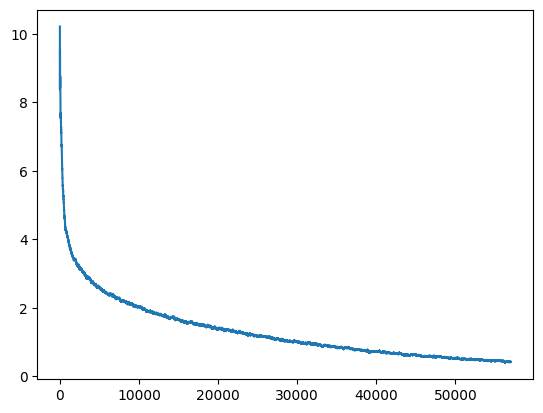

In [49]:
pd.Series(losses).ewm(100).mean().plot();

In [50]:
def translate(text, src_lang=LANGUAGE_ORIGIN_LABEL, tgt_lang=LANGUAGE_TARGET_LABEL, a=16, b=1.5, max_input_length=1024, **kwargs):
    tokenizer.src_lang = src_lang
    tokenizer.tgt_lang = tgt_lang
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=max_input_length)
    result = model.generate(
        **inputs.to(model.device),
        forced_bos_token_id=tokenizer.convert_tokens_to_ids(tgt_lang),
        max_new_tokens=int(a + b * inputs.input_ids.shape[1]),
        **kwargs
    )
    #print(inputs.input_ids.shape[1], result.shape[1])
    return tokenizer.batch_decode(result, skip_special_tokens=True)

In [51]:
xx, yy, lang1, lang2 = get_batch_pairs(1, data=df_dev)
print(xx)
print(yy)
model.eval()
print(translate(xx[0], lang1, lang2, no_repeat_ngram_size=3, num_beams=5))

["jarai chi achepchiee oonookai otta kekiikai ma'in"]
['quien entonces es el esclavo fiel y discreto']
['quien es verdaderamente el esclavo fiel y discreto a quien su amo nombro sobre sus domesticos']


In [52]:
!ls -alsh $MODEL_SAVE_PATH

total 5.2G
4.0K drwxrwxr-x  2 americasnlp americasnlp 4.0K Mar 16 10:33 .
4.0K drwxrwxr-x 10 americasnlp americasnlp 4.0K Mar 16 18:57 ..
6.6M -rw-rw-r--  1 americasnlp americasnlp 6.6M Mar 16 10:20 all_texts_file.csv
4.0K -rw-rw-r--  1 americasnlp americasnlp  848 Mar 16 22:09 config.json
4.0K -rw-rw-r--  1 americasnlp americasnlp  184 Mar 16 22:09 generation_config.json
5.2G -rw-rw-r--  1 americasnlp americasnlp 5.2G Mar 16 22:09 pytorch_model.bin
4.9M -rw-rw-r--  1 americasnlp americasnlp 4.9M Mar 16 22:09 sentencepiece.bpe.model
4.0K -rw-rw-r--  1 americasnlp americasnlp 3.5K Mar 16 22:09 special_tokens_map.json
536K -rw-rw-r--  1 americasnlp americasnlp 535K Mar 16 10:20 spm_16k.model
320K -rw-rw-r--  1 americasnlp americasnlp 317K Mar 16 10:20 spm_16k.vocab
4.9M -rw-rw-r--  1 americasnlp americasnlp 4.9M Mar 16 10:20 spm_nllb_268k.model
4.0K -rw-rw-r--  1 americasnlp americasnlp  570 Mar 16 22:09 tokenizer_config.json


<h1 id="7.-Using-the-model">7. Testing the model</h1>

In [53]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import NllbTokenizer, AutoModelForSeq2SeqLM, AutoConfig
from tqdm.auto import tqdm, trange

In [54]:
def fix_tokenizer(tokenizer, new_lang=LANGUAGE_TARGET_LABEL):
    """ Add a new language token to the tokenizer vocabulary (this should be done each time after its initialization) """
    old_len = len(tokenizer) - int(new_lang in tokenizer.added_tokens_encoder)
    tokenizer.lang_code_to_id[new_lang] = old_len-1
    tokenizer.id_to_lang_code[old_len-1] = new_lang
    # always move "mask" to the last position
    tokenizer.fairseq_tokens_to_ids["<mask>"] = len(tokenizer.sp_model) + len(tokenizer.lang_code_to_id) + tokenizer.fairseq_offset

    tokenizer.fairseq_tokens_to_ids.update(tokenizer.lang_code_to_id)
    tokenizer.fairseq_ids_to_tokens = {v: k for k, v in tokenizer.fairseq_tokens_to_ids.items()}
    if new_lang not in tokenizer._additional_special_tokens:
        tokenizer._additional_special_tokens.append(new_lang)
    # clear the added token encoder; otherwise a new token may end up there by mistake
    tokenizer.added_tokens_encoder = {}
    tokenizer.added_tokens_decoder = {}

In [55]:
model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_SAVE_PATH).cuda(CUDA_CORE)
tokenizer = NllbTokenizer.from_pretrained(MODEL_SAVE_PATH)
fix_tokenizer(tokenizer)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [56]:
def translate(text, src_lang=LANGUAGE_ORIGIN_LABEL, tgt_lang=LANGUAGE_TARGET_LABEL, a=32, b=3, max_input_length=1024, num_beams=4, **kwargs):
    tokenizer.src_lang = src_lang
    tokenizer.tgt_lang = tgt_lang
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=max_input_length)
    result = model.generate(
        **inputs.to(model.device),
        forced_bos_token_id=tokenizer.convert_tokens_to_ids(tgt_lang),
        max_new_tokens=int(a + b * inputs.input_ids.shape[1]),
        num_beams=num_beams,
        **kwargs
    )
    return tokenizer.batch_decode(result, skip_special_tokens=True)

In [57]:
t = "las canciones de amor me gustan mucho"
print(translate(t, LANGUAGE_ORIGIN_LABEL, LANGUAGE_TARGET_LABEL))

["kamalainsü ma'in tamüin tü jayeechikana apülawaa"]


In [58]:
translate(t, LANGUAGE_ORIGIN_LABEL, LANGUAGE_TARGET_LABEL, do_sample=True, num_beams=1, temperature=1.5)

["kamalainsü ma'in tamüin tü jayeechi süpüntiaka jüpüla"]

In [59]:
t = "kuyakuyllawan takitam anchata kuyani"
print(translate(t, LANGUAGE_TARGET_LABEL, LANGUAGE_ORIGIN_LABEL))

['me dieron lo que quiso decir me dieron lo que quiso decir y me dieron lo que quiso decir']


In [60]:
translate(t, LANGUAGE_TARGET_LABEL, LANGUAGE_ORIGIN_LABEL, do_sample=True, num_beams=1, temperature=1.5)

['tuve curiosidad sobre el corazon de alguien']

In [61]:
def batched_translate(texts, batch_size=8, **kwargs):
    """Translate texts in batches of similar length"""
    idxs, texts2 = zip(*sorted(enumerate(texts), key=lambda p: len(p[1]), reverse=True))
    results = []
    for i in trange(0, len(texts2), batch_size):
        results.extend(translate(texts2[i: i+batch_size], **kwargs))
    return [p for i, p in sorted(zip(idxs, results))]

In [62]:
# df_test[LANGUAGE_FILE_ORIGIN_LABEL + '_translated'] = batched_translate(df_test["LANGUAGE_FILE_TARGET_LABEL"], src_lang=LANGUAGE_TARGET_LABEL, tgt_lang=LANGUAGE_ORIGIN_LABEL)
# df_test[LANGUAGE_FILE_TARGET_LABEL + '_translated'] = batched_translate(df_test["LANGUAGE_FILE_ORIGIN_LABEL"], src_lang=LANGUAGE_ORIGIN_LABEL, tgt_lang=LANGUAGE_TARGET_LABEL)

In [63]:
df_test[LANGUAGE_FILE_ORIGIN_LABEL + '_translated'] = [translate(t, LANGUAGE_TARGET_LABEL, LANGUAGE_ORIGIN_LABEL)[0] for t in tqdm(df_test[LANGUAGE_FILE_TARGET_LABEL])]
df_test[LANGUAGE_FILE_TARGET_LABEL + '_translated'] = [translate(t, LANGUAGE_ORIGIN_LABEL, LANGUAGE_TARGET_LABEL)[0] for t in tqdm(df_test[LANGUAGE_FILE_ORIGIN_LABEL])]

  0%|          | 0/8222 [00:00<?, ?it/s]

  0%|          | 0/8222 [00:00<?, ?it/s]

In [64]:
import sacrebleu
bleu_calc = sacrebleu.BLEU()
chrf_calc = sacrebleu.CHRF(word_order=2)  # this metric is called ChrF++

In [65]:
print(bleu_calc.corpus_score(df_test[LANGUAGE_FILE_ORIGIN_LABEL + '_translated'].tolist(), [df_test[LANGUAGE_FILE_ORIGIN_LABEL].tolist()]))
print(chrf_calc.corpus_score(df_test[LANGUAGE_FILE_ORIGIN_LABEL + '_translated'].tolist(), [df_test[LANGUAGE_FILE_ORIGIN_LABEL].tolist()]))
print(bleu_calc.corpus_score(df_test[LANGUAGE_FILE_TARGET_LABEL + '_translated'].tolist(), [df_test[LANGUAGE_FILE_TARGET_LABEL].tolist()]))
print(chrf_calc.corpus_score(df_test[LANGUAGE_FILE_TARGET_LABEL + '_translated'].tolist(), [df_test[LANGUAGE_FILE_TARGET_LABEL].tolist()]))

BLEU = 13.81 37.3/17.3/10.4/6.7 (BP = 0.948 ratio = 0.949 hyp_len = 95251 ref_len = 100332)
chrF2++ = 32.62
BLEU = 14.19 37.9/18.0/10.3/6.6 (BP = 0.968 ratio = 0.969 hyp_len = 81942 ref_len = 84600)
chrF2++ = 40.51


In [66]:
pd.options.display.max_colwidth = 100

In [67]:
df_test.sample(10, random_state=42)[[LANGUAGE_FILE_TARGET_LABEL, LANGUAGE_FILE_ORIGIN_LABEL, LANGUAGE_FILE_TARGET_LABEL + '_translated', LANGUAGE_FILE_ORIGIN_LABEL + '_translated']]

,way,esp,way_translated,esp_translated
28297,jintuluiwa'aya barbara epeinjaapu'usü kasa süpüla jee saapapu'uin shiyoolo wayuu,barbara comenzo a tener visiones y a escuchar voces cuando era muy joven,ee'iyalaashi so'u tia barbara sümaa saapaain sünüiki wayuu jintüliiwa'aya shia,siendo una ni a barbara dedicaba tiempo a beber alcohol y a beber calcetines
48477,o'unüshiijese'e naya chaa laülaapialu'u süpüla nakumajüinjatüin sukuwa'ipa tia filip,no obstante ha habido ocasiones en las que hemos tenido que defender algunos derechos en los tri...,akatsa'a eein ka'i eere wo'unirüin wakuwa'ipa sulu'u tü laülaapiakat süpüla anain wakuwa'ipa,por eso se fueron a arreglar asuntos con los ancianos
71609,shiasa'a nashutapa na siiriokana saa'u israel oo'ulaashi baasa suulia akumajaa süsepü rama nüpüt...,cuando los sirios atacaron las ciudades de israel baasa de inmediato dejo de edificar a rama y s...,wanaa sümaa saja'ttinnüin israel natuma na asiriokana oo'ulaashi baasa suulia akumajaa tü pueulo...,cuando los sirios atacaron israel baasa dejo de construir las murallas de rama y renuncio a este...
5935,tashikai nnojoishi yaa miichipalu'u,papa no esta en casa,nnojoishi yaa miichipa'a tashikai,papa no esta en casa
33861,shiasa'a müin nanaajaapa na aluwataaushiikana eejaasü wanee kasa alataka,pero a finales del siglo primero la situacion cambio,a'wanajaasü sukuwa'ipa tia saja'ttiamüin tü juyakat,aquella noche estaba tan ocupado que tuvo que pasar una terrible catastrofe
62556,tnm,enviame a mi,puluwataa tayakai,no pertenece al hombre que esta andando siquiera dirigir su paso
73693,kapülewaa,dificil,kapüleesü,dificil
24710,jiasa wane ai niruin wane jühuarala siki wattas peje peje müsü jühuarakat watutapaa nia amajuchi...,una noche vio una claridad lejana que se iba acercando era un hombre a caballo llevando en la ma...,wanee ja'wai ni'raka wanee claridad wattalu'u nürütka müshija'a wanee wayuu naa'u ama nülü'üjüin...,en cambio el tio noe encontro un hoyo cerca del arbusto y cayo sobre el hombro del caballo carga...
26435,jee niirakaakalaka sümüin sotpünaa nüpülaneetaseka chi mmapa'ashajüikai,y dio un vistazo alrededor del planeta del geografo,jee ni'rakaaro'uin pülaneetase mmapa'ashajüikai,y miro a la directriz del planeta el geografo
71837,nümaka süchikijee na lotokana akuwa'ipa nayeena kepiaka saa'u tü mmakat süpüla ka'ika süpüshua'a...,y luego dice los justos mismos poseeran la tierra y residiran para siempre sobre ella,anuu soo'omüin nünüiki maleiwa na lotokana akuwa'ipa nayeena kepiaka saa'u tü mmakat süpüla ka'i...,y tambien dice los justos mismos poseeran la tierra y residiran para siempre sobre ella
